####  Дмитрий МАРЬИН   
----
###### TripAdvisor Restaurant Rating prediction  
Юнит 3. Введение в ML - Проект 3. О вкусной и здоровой пище (**RDS_04**)  

#### Порядок выполнения работы:  
+ цель работы, целевой показатель, Базовое решение (Baseline)
+ сайт проекта, список и расположение файлов с данными
+ 01 список всех используемых в работе столбцов (полей данных) с описанием
+ 02 импорт библиотек, данных, пользовательские функции, счетчик, окружение
+ 03 общая оценка датасета и данных в столбцах
+ 04 Data Preprocessing - оценка и предобработка данных в столбцах 
+ 05 EDA
+ 06 готовим файлы для модели 
+ 07 Model
+ 08 Submission

**Цель** - создать модель, использующую алгоритм **RandomForestRegression**,  которая будет прогнозировать рейтинг ресторана по версии TripAdvidor.  
**Целевый показатель** - столбец 'Rating'  
**Базовое решение** расположено тут - [Baseline nootbook](https://www.kaggle.com/itslek/baseline-sf-tripadvisor-rating-v2-7)  

#### [Описание проекта [SF-DST] Restaurant Rating prediction](https://www.kaggle.com/t/18c4256240c04280890e771864c63173)   
####   [3 файла на  Kaddle data page:](https://www.kaggle.com/c/sf-dst-restaurant-rating/data)  
+ #### [TRAINing dataset (40,000 records) -- main_task.csv => df_train](https://www.kaggle.com/c/sf-dst-restaurant-rating/data?select=main_task.csv)  
+ #### [TEST dataset (10,000 records) -- kaggle_task.csv => df_test](https://www.kaggle.com/c/sf-dst-restaurant-rating/data?select=kaggle_task.csv) 
+ #### [RESULTS template for your model -- sample_submission.csv](https://www.kaggle.com/c/sf-dst-restaurant-rating/data?select=sample_submission.csv)  

### 01. Список столбцов (полей данных):
+    'Restaurant_id' --- идентификатор ресторана / сети ресторанов  
+    'City' -- город  
+    'Cuisine Style' -- типы кухни  
+    'Ranking' -- место ресторана среди всех ресторанов города  
+    'Rating' -- рейтинг TripAdvisor => **TARGET field**  
+    'Price Range' -- диапазон цен  
+    'Number of Reviews' -- количество отзывов  
+    'Reviews' -- приведены 2 отзыва с сайта и их даты
+    'URL_TA' -- ссылка на страницу ресторана на TripAdvisor
+    'ID_TA' -- идентификатор ресторана в базе TripAdvisor  

Добавлены новые:
+    признак сетевого ресторана или бренда --'Restaurant_id_isNet'  
+    пропуски в  'Number of Reviews' --'Number_of_Reviews_isNAN'  
+    пропуски в 'Cuisine Style' -- 'Cuisine_isNAN'  
+    4 варианта количеств кухонь -- 'Cus_qty_1 -4'
+    скорректированный 'Rating' -- 'Real_rank'  
+    4 ценовых варианта из 'Price Range' -- 'P_1-4' 
+    равный частоте встречаемости 'City' -- 'City_rank'
+    31 dummies - названия городов из поля 'City'
+    пропуски в 'Reviews' -- 'Reviews_isNAN'

Удалены:
+    'Restaurant_id'
+    'City'
+    'Cuisine Style'
+    'Price Range'
+    'Cuisine Style'
+    'Reviews'

#### 02. импорт библиотек, данных, пользовательские функции, счетчик, окружение  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split 

def display_all(df):     # display all columns  or all raws
   with pd.option_context('display.max_rows', 30): # rows # to view
      with pd.option_context('display.max_columns', None): # columns
          display(df)
        
def values_table(df):
    nan_sum = df.isnull().sum()
    nan_pc = 100 * df.isnull().sum() / len(df)
    un_num = df.nunique(dropna=False)
    my_table = pd.concat([nan_sum, nan_pc, un_num], axis=1)
    my_table2 = my_table.rename(columns = {0: 'NaN', 1: 'NaN%', 2: 'unique'})
    my_table2 = my_table2[my_table2.iloc[:,1] >= 0].round(1)
    return my_table2

def nan_columns(df):
    nan_sum = df.isnull().sum()
    print('Nan fix is needed for columns:', nan_sum[nan_sum > 0], sep='\n'*2)

In [3]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [4]:
path_to_files = '' # for working offline -- uncomment
# path_to_files = '/kaggle/input/sf-dst-restaurant-rating/' # for online
df_train = pd.read_csv(path_to_files+'main_task.csv')
df_test = pd.read_csv(path_to_files+'kaggle_task.csv')
sample_submission = pd.read_csv(path_to_files+'sample_submission.csv')

In [5]:
# для обработки признаков объединяем трейн и тест в  << df >>
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['Rating'] = 0  # add extra column to test - for correct join 
df = df_test.append(df_train, sort=False).reset_index(drop=True)

# data1=df.copy() # копия чтобы можно было восстановить город после get dummies

#### 03. общая оценка датасета

In [6]:
df.sample(4)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
13295,id_1080,Warsaw,"['American', 'Pub', 'Gastropub']",1081.0,NaN,2.0,"[['Veeery nice place', 'Incredible gem in Prag...",/Restaurant_Review-g274856-d10624929-Reviews-P...,d10624929,1,5.0
14171,id_1080,Oporto,"['European', 'Portuguese']",1081.0,$$ - $$$,4.0,"[[""It's closed"", 'Lovely bakery and cafe'], ['...",/Restaurant_Review-g189180-d8571494-Reviews-Co...,d8571494,1,4.5
39498,id_990,Barcelona,"['Mediterranean', 'Spanish', 'European', 'Arge...",991.0,$$ - $$$,78.0,"[['Great food', 'Noisy, but very good'], ['09/...",/Restaurant_Review-g187497-d4783283-Reviews-Ca...,d4783283,1,4.5
623,id_623,Milan,['Pub'],2423.0,NaN,63.0,"[[], []]",/Restaurant_Review-g187849-d2320334-Reviews-Sc...,d2320334,0,0.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [8]:
fields_list = df.columns.tolist() # COLUMN NAMES list
for x in fields_list:
    print(x)

Restaurant_id
City
Cuisine Style
Ranking
Price Range
Number of Reviews
Reviews
URL_TA
ID_TA
sample
Rating


#### Суммарная оценка NaN и уникальных значений  в столбцах  

In [9]:
values_table(df)   # in joined df (test + train)

,NaN,NaN%,unique
Restaurant_id,0,0.0,13094
City,0,0.0,31
Cuisine Style,11590,23.2,10732
Ranking,0,0.0,12975
Price Range,17361,34.7,4
Number of Reviews,3200,6.4,1574
Reviews,2,0.0,41858
URL_TA,0,0.0,49963
ID_TA,0,0.0,49963
sample,0,0.0,2


**03.1** выводим список столбцов с пропусками для дальнейшей обработки

In [10]:
nan_columns(df)

Nan fix is needed for columns:

Cuisine Style        11590
Price Range          17361
Number of Reviews     3200
Reviews                  2
dtype: int64


**03.2** знакомство с признаками (**describe**) и **просмотр дубликатов**

In [11]:
x = 'Restaurant_id' # select COLUMN TO LOOKUP (describe)
df[x].describe() # freq = is the most common value’s frequency

count      50000
unique     13094
top       id_227
freq          19
Name: Restaurant_id, dtype: object

In [12]:
df2 = df.sort_values(by=[x]) # new dataframe sorted by column X!
display(df2[df2[x].duplicated(keep=False)]) # show << DUPLICATES >> in column X

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
32863,id_0,Edinburgh,"['European', 'British', 'Scottish']",1.0,$$$$,263.0,"[['Unforgettable', 'GROUP DINING EXPERIENCE DI...",/Restaurant_Review-g186525-d8479434-Reviews-Th...,d8479434,1,5.0
33201,id_0,Vienna,"['Austrian', 'European', 'Central European', '...",1.0,$$$$,241.0,"[[""Fine dining at it's best"", 'Xmas dinner'], ...",/Restaurant_Review-g190454-d7361583-Reviews-Ca...,d7361583,1,5.0
33892,id_0,Warsaw,"['Thai', 'Asian', 'Vegetarian Friendly', 'Glut...",1.0,$,108.0,"[['Great experience', 'Best Thai food out of T...",/Restaurant_Review-g274856-d12871486-Reviews-S...,d12871486,1,5.0
34120,id_0,Amsterdam,"['French', 'Dutch', 'European']",1.0,$$ - $$$,136.0,"[['Just like home', 'A Warm Welcome to Wintry ...",/Restaurant_Review-g188590-d11752080-Reviews-M...,d11752080,1,5.0
...,...,...,...,...,...,...,...,...,...,...,...
38998,id_9994,London,"['Pizza', 'Italian']",10003.0,$$ - $$$,8.0,"[['Brilliant Pizza', 'Great pizza as always'],...",/Restaurant_Review-g186338-d10533045-Reviews-B...,d10533045,1,4.5
9994,id_9994,Lisbon,"['Mediterranean', 'European', 'Portuguese']",813.0,$$ - $$$,119.0,"[['Waiting horror', 'Perfect Destination Weddi...",/Restaurant_Review-g189158-d6976663-Reviews-Pa...,d6976663,0,0.0
9995,id_9995,London,"['Caribbean', 'Barbecue', 'Jamaican', 'Vegetar...",4367.0,$,28.0,[['By far best Chicken burgers and wings in L....,/Restaurant_Review-g186338-d11916827-Reviews-C...,d11916827,0,0.0
43394,id_9995,London,"['Italian', 'Pizza', 'Mediterranean', 'Europea...",10004.0,$$ - $$$,38.0,"[['Average but worthed.', 'AL PARCO-IDEAL FOR ...",/Restaurant_Review-g186338-d3902010-Reviews-Al...,d3902010,1,3.5


+ признак **'Restaurant_id'** не уникальный, будет использован как признак сетевого ресторана
+ **'ID_TA'** имеет небольшое количество дубликатов, он входит в состав URL_TA

### 04. Data Preprocessing - оценка и предобработка - в датасете = 'df' (train + test)

----
**04.1** признак **'Restaurant_id' -- удаляем**,  
 для сетевых ресторанов **создаем **'Restaurant_id_isNet'**    

In [13]:
df['Restaurant_id_isNet'] = df.duplicated(subset=['Restaurant_id']).astype('uint8') # net = 1
df = df.drop(['Restaurant_id'], axis='columns')
df['Restaurant_id_isNet'].value_counts()

1    36906
0    13094
Name: Restaurant_id_isNet, dtype: int64

----
**04.2** признаки **'URL_TA' и 'ID_TA' -- удаляем**  

In [14]:
df = df.drop(['URL_TA', 'ID_TA'], axis='columns')

----
**04.3** признак **'Number_of_Reviews'** --  Nan заполняем нулями,  
пропуски заносим в новый признак -- **'Number_of_Reviews_isNAN'**  

In [15]:
df['Number_of_Reviews_isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')
df['Number of Reviews'].fillna(0, inplace=True)

----
**04.4** признак **'Cuisine Style'** -- **Nan** заполняем **'not specified'**, 

пропуски заносим в новый признак -- **'Cuisine_isNAN'** 

**число вариантов кухни** заносим в новый признак **'Cuisine_qty'** 

создаем **4 бинарных признака: Cus_qty_1, Cus_qty_2, Cus_qty_3, Cus_qty_4**

удаляем исходный признак **'Cuisine Style'**

In [16]:
df['Cuisine_isNAN'] = pd.isna(df['Cuisine Style']).astype('uint8')
df['Cuisine Style'].fillna("['not_specified']",inplace=True)
df['Cuisine Style'] = df['Cuisine Style'].apply(lambda x: eval(x)) # to list
df['Cuisine_qty'] = df['Cuisine Style'].apply(lambda x: len(x)) # q-ty to new column

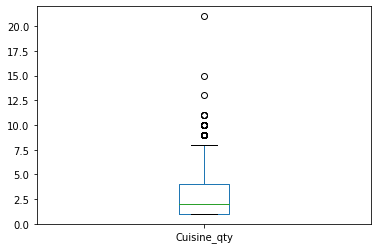

In [17]:
ax = df.Cuisine_qty.plot.box() # распределение

<AxesSubplot:xlabel='Cuisine_qty', ylabel='Rating'>

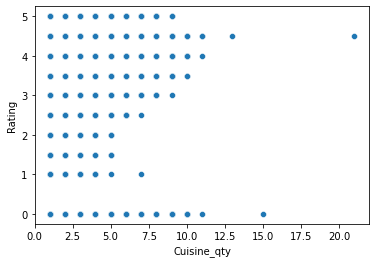

In [18]:
sns.scatterplot(data=df, x="Cuisine_qty", y="Rating") # к целевой переменной

из числа кухонь создадим **4 бинарных признака: Cus_qty_1, Cus_qty_2, Cus_qty_3, Cus_qty_4**

по числу вариантов предлагамых типов кухонь = 1, = 2, от 2 до 5, больше 5  

исходный столбец **'Cuisine Style'** удаляем

In [19]:
df['Cus_qty_1'] = df['Cuisine_qty'].apply(lambda x: 1 if x == 1 else 0)
df['Cus_qty_2'] = df['Cuisine_qty'].apply(lambda x: 2 if 1 < x <= 2 else 0)
df['Cus_qty_3'] = df['Cuisine_qty'].apply(lambda x: 3 if 2 < x <= 5 else 0)
df['Cus_qty_4'] = df['Cuisine_qty'].apply(lambda x: 4 if 5 < x else 0)
df = df.drop(['Cuisine Style'], axis='columns')

----
**04.5** признак **'Ranking'** -- добавляем признак **'Real_rank'** 

полученный делением "числа ресторанов в городе" на 'Ranking'

Из baseline решения видно, что это очень важный параметр для модели, но в исходном виде он малоинформативен. Он показывает место в городском рейтинге ресторанов, но изначально мы не знаем сколько ресторанов в городе. То есть, что бы узнать его более реалистичное значение 
 -- надо число ресторанов разделить на Ranking. Число ресторанов можно оценить по количеству записей в базе на каждый город.

In [20]:
grouped = df.groupby('City')
rest_count = grouped['City'].count() # return Series
df['Rest_qty'] = df['City'].map(rest_count) # new column with rest q-ty in city
df['Real_rank'] = df['Rest_qty'] / df['Ranking'] # new rank paramter received

<AxesSubplot:xlabel='Real_rank', ylabel='Rating'>

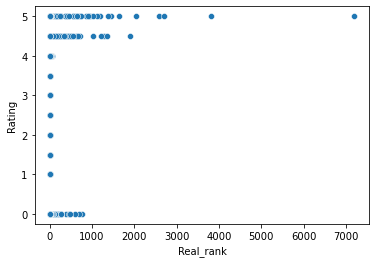

In [21]:
sns.scatterplot(data=df, x="Real_rank", y="Rating") # к целевой переменной

----
**04.6** признак **'Price Range'** 

из его 3-х категорий и Nan создаем **4 бинарных признака P_1.0 - P__3.0, P_nan**   

In [22]:
price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
df['Price Range'] = df['Price Range'].map(price_dict)
df = pd.get_dummies(df, columns=['Price Range'], prefix='P', dummy_na=True)

----
**04.7** создаем признак **'C_rev_qty'** -- для каждого города сумма 'Number of Reviews' для всех ресторанов города

In [23]:
rev_sum = df.groupby(['City'])['Number of Reviews'].sum()  # return Series
df['C_rev_qty'] = df['City'].map(rev_sum).rank(pct=True) # sum of reviews per city

----
**04.8** признак **'City'** -- создаем новый признак **City_rank** из частоты 'City' ( = value_counts)  

и используя One-Hot Encoding создаем еще **dummy-признаки для всех городов**  

In [24]:
temp_obj = df['City'].value_counts()
df['C_rank'] = df['City'].apply(lambda x: temp_obj[x]).rank(pct=True) # rank in percent

df = pd.get_dummies(df, columns=['City'], prefix='C')

----
**04.9** признак **'Reviews'** -- 
пропуски заносим в **'Reviews_isNAN'**, текстовый столбец 'Reviews' удаляем

In [25]:
df['Reviews_isNAN'] = (df['Reviews'] == '[[], []]').astype('uint8')
df = df.drop(['Reviews'], axis='columns')

----
### 05. EDA


----
**05.1** **'целевая переменная  -- 'Rating'**  


<AxesSubplot:xlabel='Rating', ylabel='Count'>

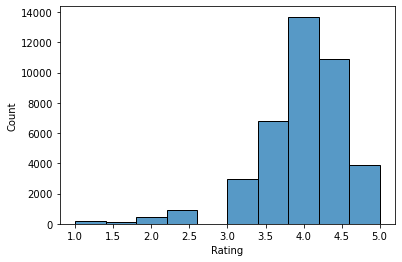

In [26]:
sns.histplot(data=df_train.Rating, bins=10,)

----
**05.2** **оценка корреляций**  


In [27]:
df_0 = df # USE TEMPORARY DATASET for charts
# re-arrange columns - column 'Rating' to be first column
temp_ser = df_0['Rating'] # data Series from 'Rating'
df_0 = df_0.drop(columns=['Rating'])
df_0.insert(loc=0, column='Rating', value=temp_ser)
df_0 = df_0.drop(columns=['sample'])

**матрица корреляций** целевое значение 'Rating' в первом столбце

<AxesSubplot:>

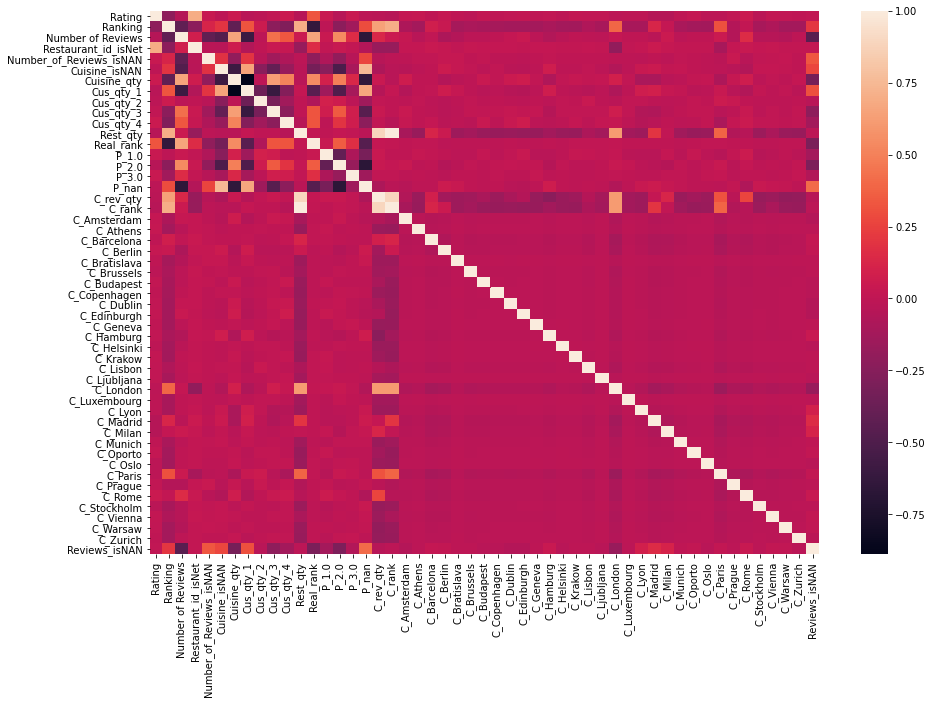

In [28]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(df_0.corr(method ='spearman'))

### корреляция между целевым и остальными параметрами

In [29]:
df_m = df_0.corr(method ='spearman')
most_correlated = df_m.abs()['Rating'].sort_values(ascending=False)
print(most_correlated.head(10).round(2))

Rating                 1.00
Restaurant_id_isNet    0.69
Real_rank              0.32
Ranking                0.21
C_Rome                 0.05
Cuisine_qty            0.05
Cus_qty_4              0.05
Number of Reviews      0.05
C_Milan                0.05
P_1.0                  0.05
Name: Rating, dtype: float64


существенно коррелируют с целевой переменной:  
+ Restaurant_id_isNet  
+ Real_rank    
+ Ranking  

между остальными признаками сильных корреляций нет

### 06. готовим файлы для модели
**5 файлов: test_data,  train_data,  X,  X_train,  X_test**

In [30]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [31]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [32]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 51), (40000, 51), (40000, 50), (32000, 50), (8000, 50))

### 07. Model  
Сам ML - скопировано из [Baseline nootbook](https://www.kaggle.com/itslek/baseline-sf-tripadvisor-rating-v2-7)  

In [33]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [34]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [35]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [36]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20677125000000002


<AxesSubplot:>

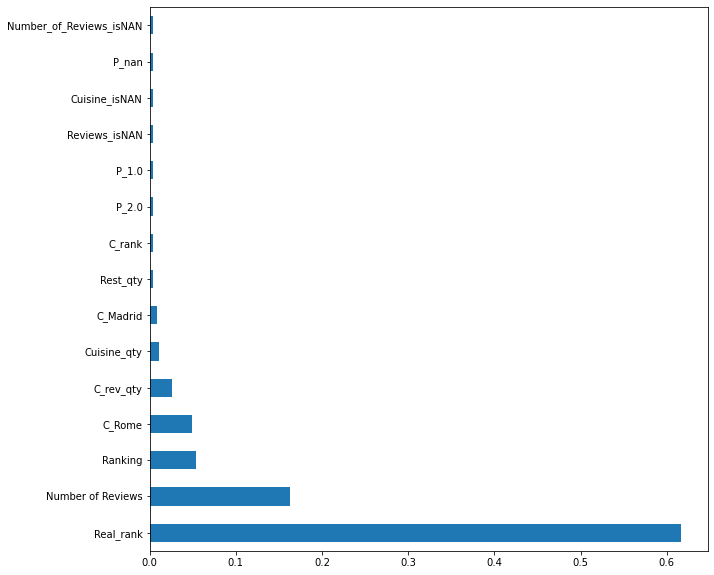

In [37]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

### 08. Submission
Если все устраевает - готовим Submission на кагл

In [39]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,Restaurant_id_isNet,Number_of_Reviews_isNAN,Cuisine_isNAN,Cuisine_qty,Cus_qty_1,Cus_qty_2,Cus_qty_3,...,C_Oporto,C_Oslo,C_Paris,C_Prague,C_Rome,C_Stockholm,C_Vienna,C_Warsaw,C_Zurich,Reviews_isNAN
3580,4491.0,12.0,0.0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8638,1907.0,121.0,0.0,0,0,0,5,0,0,3,...,0,0,0,0,0,0,0,0,0,0
4618,8842.0,8.0,0.0,0,0,1,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
7394,1689.0,20.0,0.0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6067,6208.0,5.0,0.0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
9362,1093.0,103.0,0.0,0,0,0,5,0,0,3,...,0,0,0,0,0,0,0,0,0,0
2867,1487.0,6.0,0.0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5838,379.0,229.0,0.0,0,0,0,5,0,0,3,...,0,0,0,0,0,0,0,1,0,0
734,347.0,222.0,0.0,0,0,0,4,0,0,3,...,0,0,0,0,0,0,0,0,0,0
7619,2201.0,0.0,0.0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [40]:
test_data = test_data.drop(['Rating'], axis=1)

In [41]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [42]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [43]:
predict_submission

array([3.02 , 4.205, 4.54 , ..., 3.045, 4.5  , 4.275])

In [44]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.020
1,id_1,4.205
2,id_2,4.540
3,id_3,4.200
4,id_4,4.445
5,id_5,4.635
6,id_6,2.720
7,id_7,2.435
8,id_8,4.135
9,id_9,4.660
